In [415]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label

In [3]:
DEBUG=True

In [4]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for ((x1, y1), (x2, y2)) in bboxes:
        if DEBUG:
            print(x1,y1,x2,y2)
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

276 500 377 570
828 500 1135 679


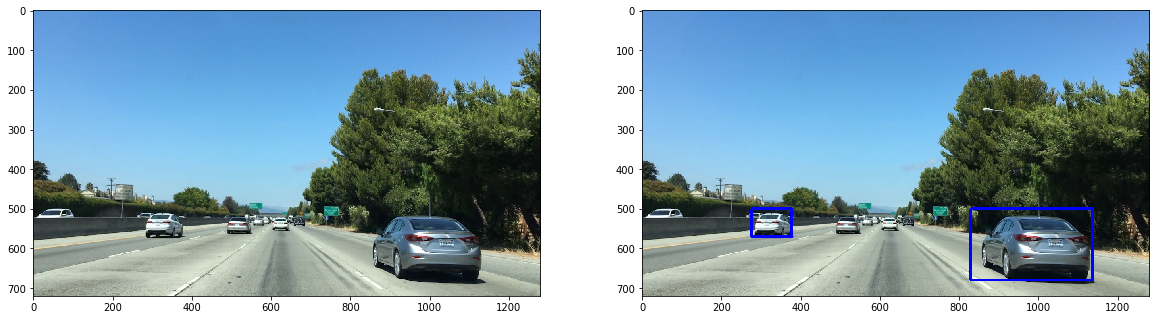

In [5]:
image = mpimg.imread('test_images/bbox-example-image.jpg')
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((276, 500), (377, 570)), ((828, 500), (1135, 679))]
result = draw_boxes(image, bboxes)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
ax1.imshow(image)
ax2.imshow(result)

In [6]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    # Read in templates one by one
    # Use cv2.matchTemplate() to search the image
    #     using whichever of the OpenCV search methods you prefer
    # Use cv2.minMaxLoc() to extract the location of the best match
    # Determine bounding box corners for the match
    # Return the list of bounding boxes
    
    for t_file in template_list:
        templ = mpimg.imread(t_file)
        res = cv2.matchTemplate(img, templ, method=cv2.TM_SQDIFF_NORMED)
        _,_,min_loc,_ = cv2.minMaxLoc(res)
        corners = (min_loc, (min_loc[0]+templ.shape[1], min_loc[1]+templ.shape[0]))
        bbox_list.append(corners)
        
    return bbox_list

275 510 381 573
488 518 550 564
554 522 583 544
601 522 647 556
657 517 686 546
849 512 1136 679


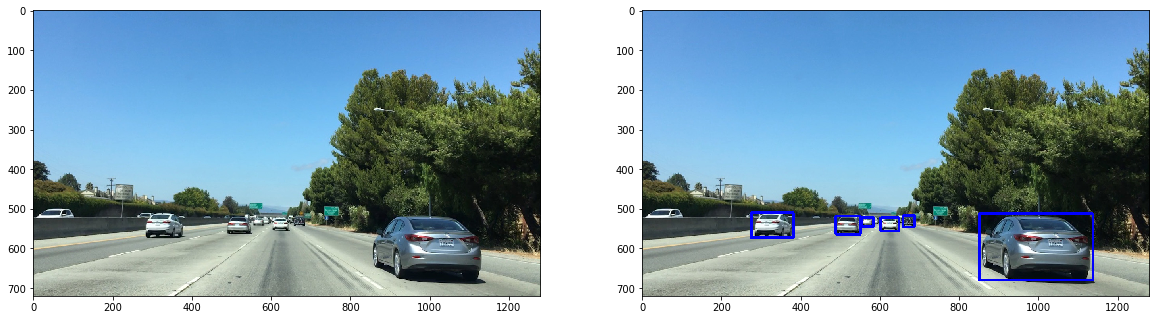

In [7]:
image = mpimg.imread('test_images/bbox-example-image.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
templist = ['test_images/cutout1.jpg', 'test_images/cutout2.jpg', 'test_images/cutout3.jpg',
            'test_images/cutout4.jpg', 'test_images/cutout5.jpg', 'test_images/cutout6.jpg']
bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
ax1.imshow(image)
ax2.imshow(result)

In [8]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist =  np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist =  np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist =  np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector  
    return hist_features,rhist, ghist, bhist, bin_centers

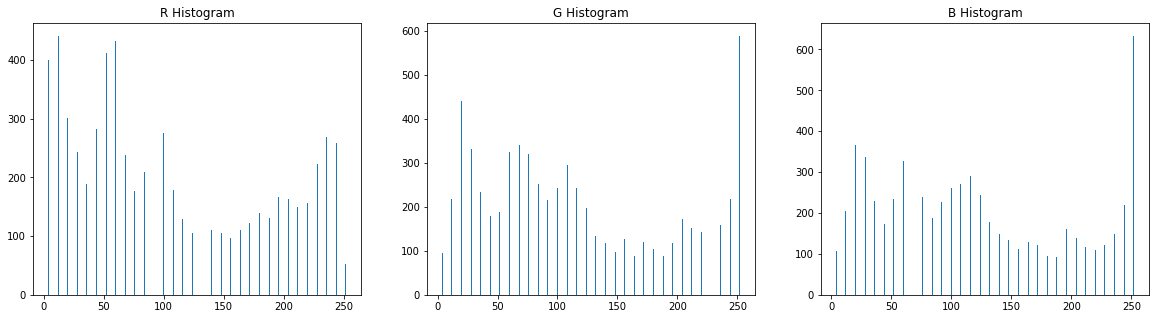

In [9]:
image = mpimg.imread('test_images/cutout1.jpg')
feature_vec, rh, gh, bh, bincen = color_hist(image, nbins=32, bins_range=(0, 256))
#print(rh,gh,bh,feature_vec)
# Plot a figure with all three bar charts
_, ax = plt.subplots(1,3, figsize=(20,5))
fig = plt.figure(figsize=(12,3))
ax[0].bar(bincen, rh[0])
ax[0].set_title('R Histogram')
    
ax[1].bar(bincen, gh[0])
ax[1].set_title('G Histogram')
    
ax[2].bar(bincen, bh[0])
ax[2].set_title('B Histogram')

In [10]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    resized = cv2.resize(img,size)
    features = resized.ravel() # Remove this line!
    # Return the feature vector
    return features, resized

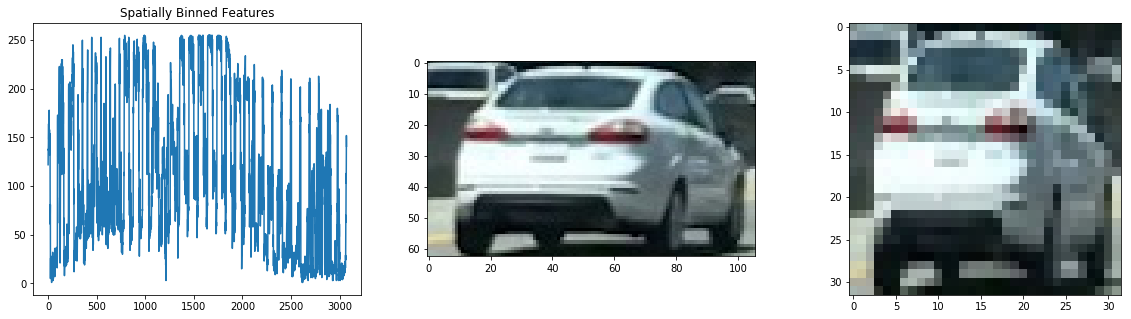

In [11]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('test_images/cutout1.jpg')
feature_vec, resized = bin_spatial(image, color_space='RGB', size=(32, 32))
# Plot features
_, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].plot(feature_vec)
ax[0].set_title('Spatially Binned Features')
ax[1].imshow(image)
ax[2].imshow(resized)

In [12]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = mpimg.imread(car_list[0]).shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = mpimg.imread(car_list[0]).dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


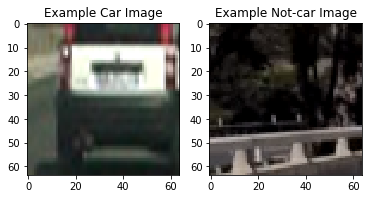

In [513]:
images = glob.glob('./*vehicles/*vehicles/*/*.png')
cars = []
notcars = []

for image in images:   
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [223]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vector=True, viz=False):
    # Use skimage.hog() to get both features and a visualization
    hog_image = None
    if viz:
        features, hog_image = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=viz, feature_vector=feature_vector)# Remove this line
    else:        
        features = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), visualise=viz, feature_vector=feature_vector)# Remove this line

    return features, hog_image

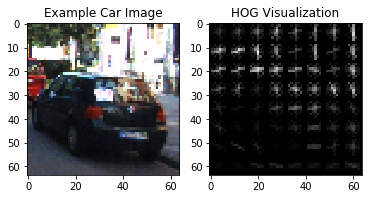

In [514]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, False,True)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [20]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
    for im_f in imgs:
        img = mpimg.imread(im_f)
        val = bin_spatial(img)[0]
        hist = color_hist(img)[0]
        feature = np.append(val, hist)
        features.append(feature)
    # Return list of feature vectors
    return features

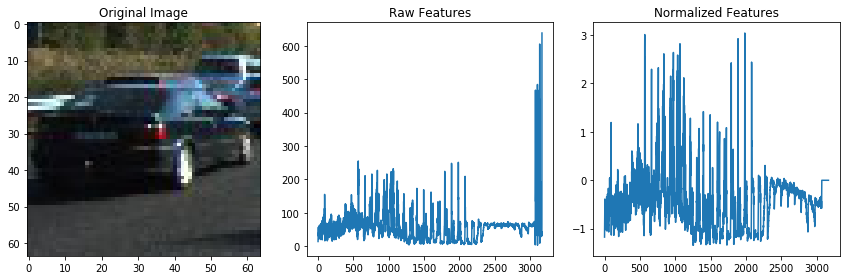

In [21]:
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

In [22]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
spatial = 32
histbin = 32
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
3.59 Seconds to train SVC...
Test Accuracy of SVC =  0.929
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  1.]
0.00233 Seconds to predict 10 labels with SVC


In [25]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block)[0])
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block)[0]
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [26]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

36.73 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9441
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.00225 Seconds to predict 10 labels with SVC


In [243]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    #print(img.shape)
    if x_start_stop[0] is None:
        x_start_stop[0]=0
    if x_start_stop[1] is None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
        
    for x in range(x_start_stop[0], x_start_stop[1], int((1.0-xy_overlap[0])*xy_window[0])):
        for y in range(y_start_stop[0], y_start_stop[1], int((1.0-xy_overlap[1])*xy_window[1])):
            #print((x,y),(x+xy_window[0],y+xy_window[1]))
            window_list.append(((x,y),(x+xy_window[0],y+xy_window[1])))
        
    # Return the list of windows
    return window_list

(720, 1280, 3)


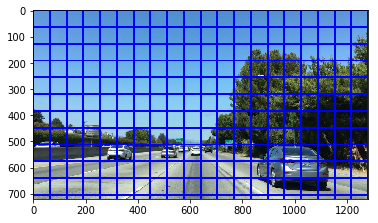

In [60]:
image = mpimg.imread('test_images/bbox-example-image.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [523]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #t=time.time()
        image = mpimg.imread(file)
        #t1=time.time()
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        #t2=time.time()
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)[0]
            #print(len(spatial_features))
            file_features.append(spatial_features)
        #t3=time.time()
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)[0]
            file_features.append(hist_features)
            print(len(hist_features))

        #t4=time.time()
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block,True, False)[0])
                hog_features = np.ravel(hog_features)
                #print(len(hog_features))
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, True, False)[0]
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        #t5=time.time()
        features.append(np.concatenate(file_features))
        #print("{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}".format(t-t1,t1-t2,t2-t3,t3-t4,t4-t5))
    # Return list of feature vectors
    return features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    img = img.astype(np.float32)/255
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)[0]
        #4) Append features to list
        img_features.append(spatial_features)
        #print(len(spatial_features))
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)[0]
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, True, False)[0])      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, True, False)[0]
        #8) Append features to list
        #print(len(hog_features))
        img_features.append(hog_features)
    #print(np.concatenate(img_features).shape)
    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #print(features.shape)
        #5) Scale extracted features to be fed to classifier
        #print(scaler.scale_.shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [297]:
def get_configs():
    while(True):
        for color_space in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
            for orient in [9,8,10]:
                for pix_per_cell in [8,6,10]:
                    for cell_per_block in [2,4]:
                        for hog_channel in ['ALL',0,1,2]:
                            for spatial_feat in [True, False]:
                                    if spatial_feat == False:
                                        continue
                                            
                                    print(color_space, orient, pix_per_cell, cell_per_block,hog_channel,spatial_feat)
                                    yield [color_space, orient, pix_per_cell, cell_per_block,hog_channel,spatial_feat]

In [357]:
### TODO: Tweak these parameters and see how the results change.
def extract_and_train(color_space = 'RGB',orient = 9,pix_per_cell = 8,cell_per_block = 2,hog_channel = 'ALL',
                      spatial_feat = True):
    #color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #orient = 9  # HOG orientations
    #pix_per_cell = 8 # HOG pixels per cell
    #cell_per_block = 2 # HOG cells per block
    #hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    #spatial_feat = True
    # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off

    
    
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2=time.time()
    print(round(t2-t, 2), 's to extract')
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    #print('Using:',orient,'orientations',pix_per_cell,
    #    'pixels per cell and', cell_per_block,'cells per block')
    #print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC(C=0.1)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 's to train','Accuracy=', round(svc.score(X_test, y_test), 4))
    # Check the score of the SVC
    print()
    # Check the prediction time for a single sample
    t=time.time()
    #print(X_scaler.scale_.shape)


    return svc, X_scaler

In [ ]:
for config in get_configs():
    svc, X_scaler = extract_and_train(*config)

In [515]:
svc, X_scaler = extract_and_train(color_space='YUV')

74.32 s to extract
24.77 s to train Accuracy= 0.991



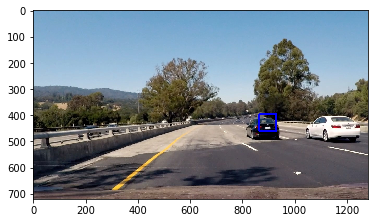

In [525]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)
y_start_stop = [300, None] # Min and max in y to search in slide_window()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

color_space="YUV"
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
spatial_feat = True
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [547]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    #Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, False, False)[0]
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, False, False)[0]
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, False, False)[0]
    
    boxes=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print(hog_features.shape)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)[0]
            #hist_features = color_hist(subimg, nbins=hist_bins)[0]
            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hog_features))
            #print(test_features.shape)
            test_features = X_scaler.transform(test_features.reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            #xbox_left = np.int(xleft*scale)
            #ytop_draw = np.int(ytop*scale)
            #win_draw = np.int(window*scale)
            #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,255),1) 
            #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))    
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, boxes

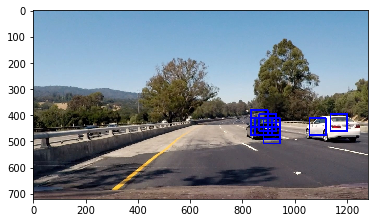

In [548]:
img = mpimg.imread('test_images/test4.jpg')
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

ystart = 300
ystop =  700
scale = 1.0
    
out_img, box_list = find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

In [817]:
class Bbox:
    cord = None
    last_seen = 0
    first_seen = 0
    idx = -1
    last_cords = []
    

In [889]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def extend_heatmap(labels, heatmap):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        if nonzero is None:
            continue
    
        heatmap[nonzero] = np.max(heatmap[nonzero])
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        heatmap[np.min(nonzerox):np.max(nonzerox), np.min(nonzeroy):np.max(nonzeroy)] = np.max(heatmap[nonzero])
        
    return heatmap

def draw_labeled_bboxes(img, labels, heatmap, threshold):
    global bboxes
    
    bboxes.curr_cord_list = []
    #print("frame {}".format(bboxes.frame_count))
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        #print("car_number=", car_number)
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        if nonzero is None:
            continue
            
        heatmap[nonzero] = np.max(heatmap[nonzero])
        if np.max(heatmap[nonzero]) <= threshold:
            #print("below threshold")
            continue
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        cord = [[np.min(nonzerox), np.min(nonzeroy)], [np.max(nonzerox), np.max(nonzeroy)]]
        bboxes.curr_cord_list.append(cord)
       
        create = True
        
        for prev_box in bboxes.bbox_list:
            if (np.abs(prev_box.cord[0][0]-cord[0][0])) < 20 and\
               (np.abs(prev_box.cord[0][1]-cord[0][1])) < 20 and\
               (np.abs(prev_box.cord[1][0]-cord[1][0])) < 20 and\
               (np.abs(prev_box.cord[1][1]-cord[1][1])) < 20:
                        
                #print("Seeing bbox{}:{} with cords{} again".format(prev_box.idx, prev_box.last_cords, cord))
                prev_box.cord[0][0] = int(0.7*np.average(prev_box.last_cords[:][0][0])  + 0.3*cord[0][0])
                prev_box.cord[0][1] = int(0.7*np.average(prev_box.last_cords[:][0][1])  + 0.3*cord[0][1])
                prev_box.cord[1][0] = int(0.7*np.average(prev_box.last_cords[:][1][0])  + 0.3*cord[1][0])
                prev_box.cord[1][1] = int(0.7*np.average(prev_box.last_cords[:][1][1])  + 0.3*cord[1][1])

                prev_box.last_cords = prev_box.last_cords[-9:] + cord
                prev_box.last_seen = bboxes.frame_count
                    
                create = False
                break
            
        if create == True:
            bbox = Bbox()
            bbox.idx = bboxes.next_idx
            bbox.first_seen = bboxes.frame_count
            bbox.cord = cord
            
            bbox.last_cords = bbox.last_cords[-9:] + cord
            bbox.last_seen = bboxes.frame_count
            
            bboxes.next_idx += 1
            bboxes.bbox_list.append(bbox)
            
            #print("Adding new bbox{} with cord{}".format(bbox.idx, cord))
             
        # Draw the box on the image
        #cv2.rectangle(img, (cord[0][0],cord[0][1]), (cord[1][0], cord[1][1]), (0,0,255), 6)
    
    for bbox in bboxes.bbox_list:
        if bbox.last_seen == bboxes.frame_count:
            #print("box{} seen this frame".format(bbox.idx))
            if bboxes.frame_count > 5 and  (bboxes.frame_count-bbox.first_seen) < 5:
                #print("was first seen in frame{} , ignoring".format(bbox.first_seen))
                continue
            cord = bbox.cord
            cv2.rectangle(img, (cord[0][0],cord[0][1]), (cord[1][0], cord[1][1]), (0,0,255), 6)
       # else:
            #print("box{} seen this frame".format(bbox.idx))
            
    bboxes.frame_count += 1
        #Return the image
    return img

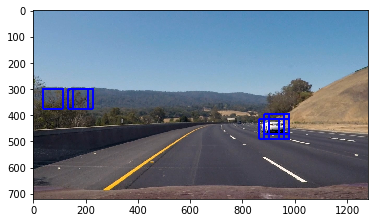

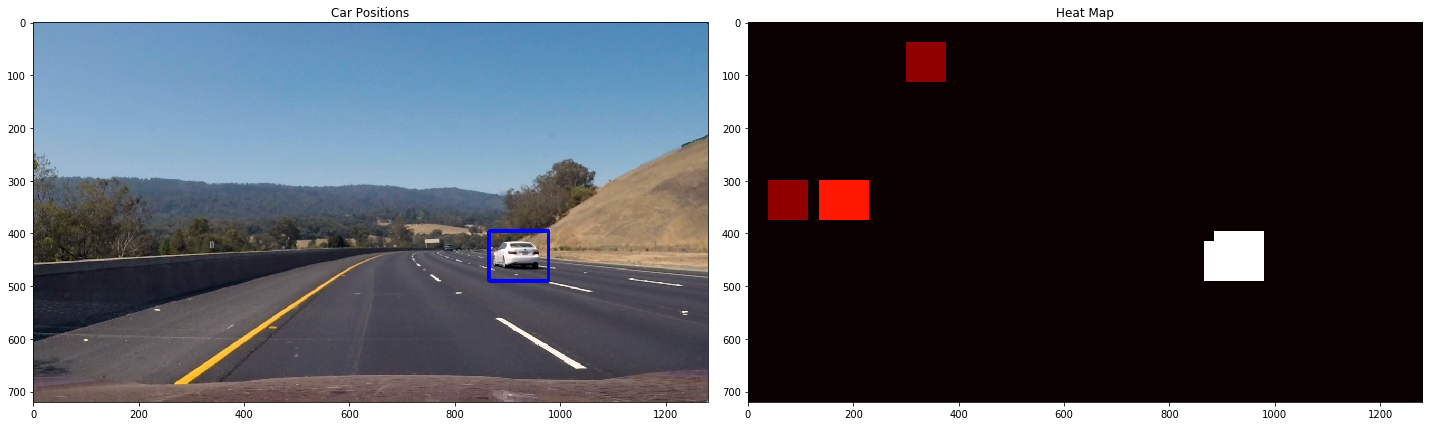

In [881]:
class Bboxes:
    frame_count = 0
    bbox_list = []
    curr_cord_list = []
    next_idx = 0
    
    def __init__(self):
        frame_count = 0
        bbox_list = []
        curr_cord_list = []
        next_idx = 0


color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

ystart = 300
ystop =  700
scale = 1.2
    
image = mpimg.imread('test_images/test3.jpg')

out_img, box_list = find_cars(image, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)
plt.show()

# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
if heatmap is None:
    print("heatmap is none")

# Find final boxes from heatmap using label function
labels = label(heatmap)
heatmap = extend_heatmap(labels, heatmap)
labels = label(heatmap)
bboxes = Bboxes() 
draw_img = draw_labeled_bboxes(np.copy(image), labels, heatmap, 2.0)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [890]:
def process_image(img):
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    ystart = 300
    ystop =  700
    scale = 1.2
    
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    
    _, box_list = find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, box_list)
    #heat = apply_threshold(heat, 0)
    heatmap = np.clip(heat, 0, 255)
    if heatmap is None:
        print("heatmap is none")
        
    labels = label(heatmap)
    heatmap = extend_heatmap(labels, heatmap)
    labels = label(heatmap)
    bboxes = Bboxes() 
    
    if heatmap is None:
        print("heatmap is none")
        
    draw_img = draw_labeled_bboxes(np.copy(img), labels, heatmap, 3.0)
    return draw_img


In [891]:
class Bboxes:
    frame_count = 0
    bbox_list = []
    curr_cord_list = []
    next_idx = 0
    
    def __init__(self):
        frame_count = 0
        bbox_list = []
        curr_cord_list = []
        next_idx = 0
        
bboxes = Bboxes() 
output = 'project_video_out_clipped.mp4'
clip_in = VideoFileClip("./project_video.mp4")
#clip_in = clip_in.subclip(29.0,34.0)
clip_out = clip_in.fl_image(process_image)
%time clip_out.write_videofile(output, audio=False, verbose=False)





  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<13:10,  1.59it/s]



  0%|          | 2/1261 [00:01<12:21,  1.70it/s]



  0%|          | 3/1261 [00:01<11:50,  1.77it/s]



  0%|          | 4/1261 [00:02<11:31,  1.82it/s]



  0%|          | 5/1261 [00:02<11:08,  1.88it/s]



  0%|          | 6/1261 [00:03<10:49,  1.93it/s]



  1%|          | 7/1261 [00:03<10:31,  1.99it/s]



  1%|          | 8/1261 [00:04<10:22,  2.01it/s]



  1%|          | 9/1261 [00:04<10:10,  2.05it/s]



  1%|          | 10/1261 [00:05<10:07,  2.06it/s]



  1%|          | 11/1261 [00:05<10:14,  2.03it/s]



  1%|          | 12/1261 [00:06<10:16,  2.02it/s]



  1%|          | 13/1261 [00:06<10:20,  2.01it/s]



  1%|          | 14/1261 [00:07<10:22,  2.00it/s]



  1%|          | 15/1261 [00:07<10:25,  1.99it/s]



  1%|▏         | 16/1261 [00:08<10:25,  1.99it/s]



  1%|▏         | 17/1261 [00:08<10:36,  1.95it/s]



  1%|▏         | 18/1261 [00:09<10:27,  1.98it/s]



  2%|▏ 

CPU times: user 12min 14s, sys: 8.13 s, total: 12min 23s
Wall time: 10min 44s


In [874]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))